# Importing Library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [3]:
train_dir = '../Emotion-Detection/data/train/'
test_dir = '../Emotion-Detection/data/test/'

row = 48
col = 48
classes = len(os.listdir(train_dir))

# Dataset Preprocessing

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   zoom_range = 0.3,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 batch_size = 64,
                                                 target_size = (row, col),
                                                 shuffle = True,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale=1/255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size = 64,
                                            target_size = (row, col),
                                            shuffle = True,
                                            color_mode = 'grayscale',
                                            class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Creating The Model Convolutional Neural Network

In [6]:
def get_model(input_size, classes = 7):
  
  model = tf.keras.Sequential()
  
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_size, activation = 'relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(7, activation = 'softmax'))
  
  model.compile(optimizer = Adam(lr=0.0001, decay=1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

In [7]:
model = get_model((row, col, 1), classes)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 17:12:22.560210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 17:12:22.560562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/Users/fbrynpk/Desktop/Emotion-Detection/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
chk_path = 'model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(chk_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=6, verbose=1, min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [11]:
steps_per_epoch = training_set.n//training_set.batch_size
validation_steps = test_set.n//test_set.batch_size

hist = fernet.fit(training_set,
                  validation_data = test_set,
                  epochs = 150,
                  callbacks = callbacks,
                  steps_per_epoch = steps_per_epoch,
                  validation_steps = validation_steps)

Epoch 1/150
448/448 [==============================] - ETA: 0s - loss: 2.4804 - accuracy: 0.4252
Epoch 1: val_accuracy improved from -inf to 0.46191, saving model to model.h5
448/448 [==============================] - 30s 67ms/step - loss: 2.4804 - accuracy: 0.4252 - val_loss: 2.2473 - val_accuracy: 0.4619 - lr: 1.0000e-04
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 2.1910 - accuracy: 0.4417
Epoch 2: val_accuracy improved from 0.46191 to 0.48256, saving model to model.h5
448/448 [==============================] - 31s 68ms/step - loss: 2.1910 - accuracy: 0.4417 - val_loss: 1.9856 - val_accuracy: 0.4826 - lr: 1.0000e-04
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 1.9496 - accuracy: 0.4672
Epoch 3: val_accuracy improved from 0.48256 to 0.50823, saving model to model.h5
448/448 [==============================] - 31s 68ms/step - loss: 1.9496 - accuracy: 0.4672 - val_loss: 1.7617 - val_accuracy: 0.5082 - lr: 1.0000e-04
Epoch 4/150
448/448

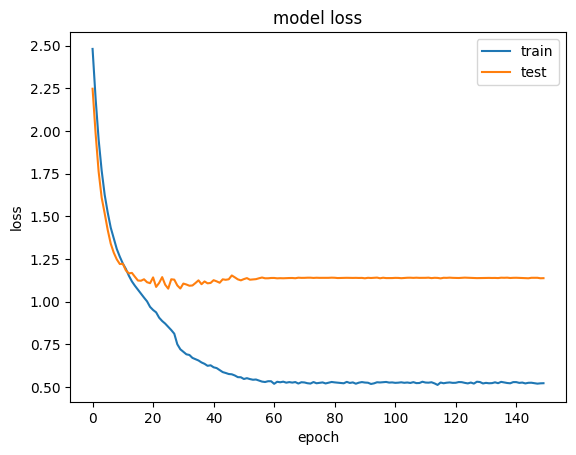

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

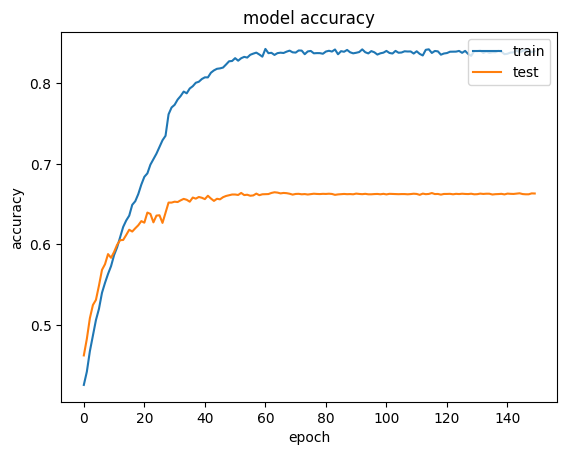

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [14]:
fernet = load_model('../Emotion-Detection/model/fernet.h5')
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

2023-02-03 18:28:32.391223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 3s 26ms/step - loss: 1.1830 - accuracy: 0.6726
final train accuracy = 90.67 , validation accuracy = 67.26


In [15]:
model = load_model('../Emotion-Detection/model/model.h5')

face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

cap=cv2.VideoCapture(0)

labels_dict={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

while True:

    ret,img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray,1.3,3) 

    for (x,y,w,h) in faces:
    
        face_img = gray[y:y+w,x:x+w]
        resized = cv2.resize(face_img,(48,48))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,48,48,1))
        result = model.predict(reshaped)

        label = np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.rectangle(img,(x,y-40),(x+w,y),(0,0,0),-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)    

        
    cv2.imshow('Emotion Recognition',img)
#     out.write(img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
    if ret==False:
        break
        
cv2.destroyAllWindows()
cap.release()

1/1 [==============================] - 0s 16ms/step


2023-02-03 18:29:08.240692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step
